In [1]:
# imports 1
import os
import shutil
import zipfile
import requests

from pathlib import Path

# imports 2  
import librosa
import librosa.display as display
import numpy as np
import pandas as pd
import IPython.display as ipd
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import wave

In [10]:
data_url = 'https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip?download=1'
data = requests.get(data_url)

with open('./RAVDESS_Audio_Speech.zip','wb') as f:
    f.write(data.content)

In [11]:
path = Path('dataset')
speech_fname = 'RAVDESS_Audio_Speech.zip'
path_speech = os.path.join(path, speech_fname)

In [12]:
if not os.path.exists(path):
    os.mkdir(path)
else:
    print (f"{path} folder already exists.")

dataset folder already exists.


In [13]:
if os.path.isfile(speech_fname):
    shutil.move(speech_fname, path)
elif os.path.isfile(path_speech):
    print(f'{speech_fname} already copied.')
else:
    print(f'{speech_fname} not found.')

In [14]:
with zipfile.ZipFile(path_speech, 'r') as zip_ref:
    zip_ref.extractall(path_speech.split('.')[0])

In [2]:
dataset_path = Path('dataset/RAVDESS_Audio_Speech/')
dir_list = os.listdir(dataset_path)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
    subf_path = os.path.join(dataset_path,i)
    fname = os.listdir(subf_path)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(os.path.join(subf_path,f))
        

RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] = RAV_df.gender + '_' + RAV_df.emotion 
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df.head()

,gender,emotion,labels,path
0,male,angry,male_angry,dataset/RAVDESS_Audio_Speech/Actor_01/03-01-05...
1,male,neutral,male_neutral,dataset/RAVDESS_Audio_Speech/Actor_01/03-01-02...
2,male,disgust,male_disgust,dataset/RAVDESS_Audio_Speech/Actor_01/03-01-07...
3,male,neutral,male_neutral,dataset/RAVDESS_Audio_Speech/Actor_01/03-01-02...
4,male,surprise,male_surprise,dataset/RAVDESS_Audio_Speech/Actor_01/03-01-08...


In [3]:
RAV_df.labels.value_counts()

female_neutral     144
male_neutral       144
male_surprise       96
female_sad          96
male_angry          96
male_sad            96
female_angry        96
female_happy        96
male_happy          96
female_fear         96
female_disgust      96
male_disgust        96
male_fear           96
female_surprise     96
Name: labels, dtype: int64

In [4]:
print(f'Emotions: {RAV_df["emotion"].unique()}')

Emotions: ['angry' 'neutral' 'disgust' 'surprise' 'happy' 'fear' 'sad']


In [5]:
emotion = 'neutral'
idx = 0
fpath = RAV_df['path'][RAV_df['emotion'] == emotion].iloc[idx]
sr = int(48e3)

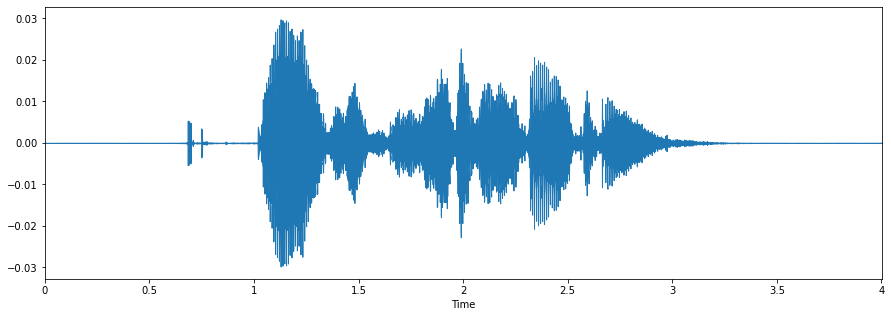

In [6]:
# Time domain plot for speech with certain emotion

data, sampling_rate = librosa.load(fpath, sr=sr)
plt.figure(figsize=(15, 5))
display.waveplot(data, sr=sampling_rate)


# audio display for selected speech
ipd.Audio(data, rate=sampling_rate)

In [7]:
fname_list = RAV_df['path']

frame_rates = []
n_channels = []
for fname in fname_list:
    with wave.open(fname, "rb") as wave_file:
        frame_rates.append(wave_file.getframerate())


if all(frame == frame_rates[0] for frame in frame_rates):
    print(f'All audio files have sample rate = {frame_rates[0]}Hz')
else:
    print('There are audios with different sample rates')

All audio files have sample rate = 48000Hz


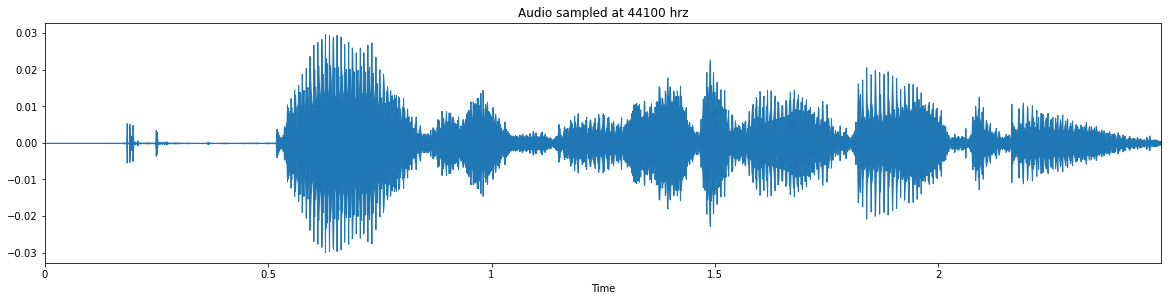

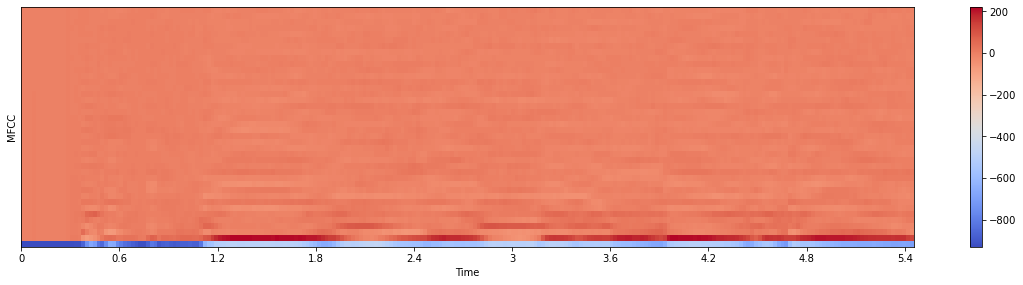

In [8]:
duration = 2.5
offset = 0.5

X, sample_rate = librosa.load(fpath, res_type='kaiser_fast', duration=duration, sr=sr, offset=offset)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(X, rate=sample_rate)

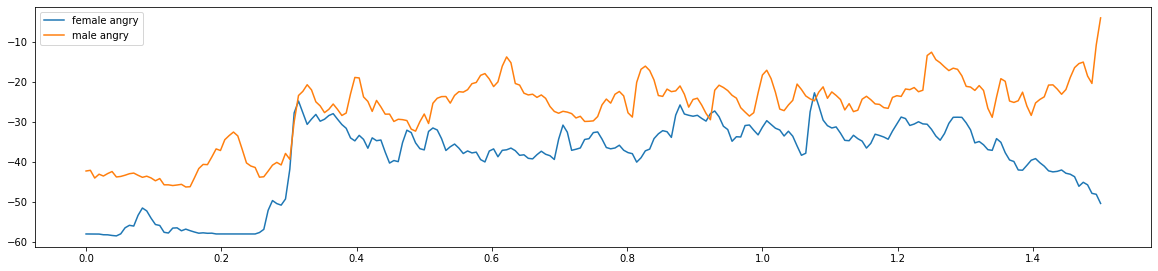

In [9]:
# Source - RAVDESS; Gender - Female; Emotion - Angry 
path_female_angry = RAV_df['path'][RAV_df['labels']=='female_angry'].iloc[1]
X_female, sample_rate = librosa.load(path_female_angry, res_type='kaiser_fast', duration=2.5, sr=sr, offset=0.5)  
female = librosa.feature.mfcc(y=X_female, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X_female, sr=sample_rate, n_mfcc=13), axis=0)

# Source - RAVDESS; Gender - Male; Emotion - Angry 
path_male_angry = RAV_df['path'][RAV_df['labels']=='male_angry'].iloc[1]
X_male_angry, sample_rate = librosa.load(path_male_angry, res_type='kaiser_fast', duration=2.5, sr=sr, offset=0.5)  
male = librosa.feature.mfcc(y=X_male_angry, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X_male_angry, sr=sample_rate, n_mfcc=13), axis=0)

# Time vector

audio_len = len(X_female)/sr
time = np.linspace(0, audio_len - 1, len(female))

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(time, female, label='female angry')
plt.plot(time, male, label='male angry')
plt.legend()
plt.show()

In [51]:
audio_len

2.296875

In [50]:
time[-1]

1.296875

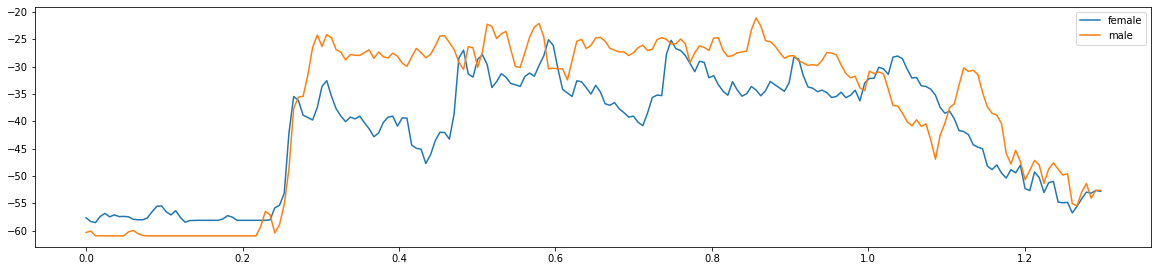

In [47]:
# Source - RAVDESS; Gender - Female; Emotion - happy 
path = RAV_df['path'][RAV_df['labels']=='female_happy'].iloc[1]
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)

# Source - RAVDESS; Gender - Male; Emotion - happy 
path = RAV_df['path'][RAV_df['labels']=='male_happy'].iloc[1]
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)

# Time vector
audio_len = len(X)/sr
time = np.linspace(0, audio_len - 1, len(female))

# Plot the two audio waves together
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(time, female, label='female')
plt.plot(time, male, label='male')
plt.legend()
plt.show()

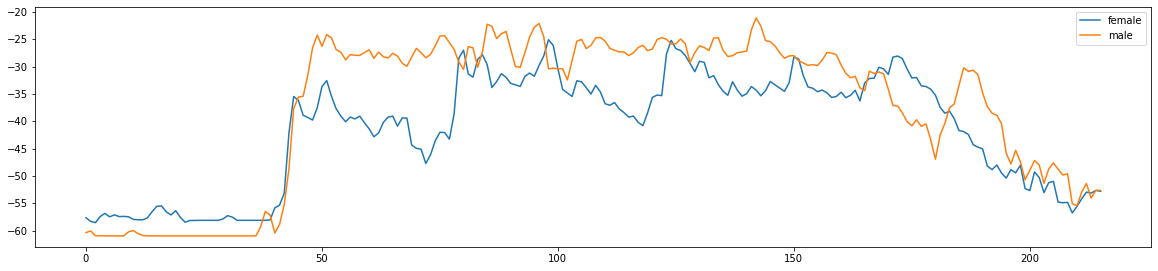

In [33]:
# Source - RAVDESS; Gender - Female; Emotion - happy 
path = RAV_df['path'][RAV_df['labels']=='female_happy'].iloc[1]
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)

# Source - RAVDESS; Gender - Male; Emotion - happy 
path = RAV_df['path'][RAV_df['labels']=='male_happy'].iloc[1]
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)

# Plot the two audio waves together
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend()
plt.show()

In [34]:
RAV_df.to_csv('RAVDESS_dataframe.csv', index=False)

In [35]:
df = pd.read_csv('RAVDESS_dataframe.csv')

In [36]:
df.head()

,gender,emotion,labels,path
0,male,angry,male_angry,dataset/RAVDESS_Audio_Speech/Actor_01/03-01-05...
1,male,neutral,male_neutral,dataset/RAVDESS_Audio_Speech/Actor_01/03-01-02...
2,male,disgust,male_disgust,dataset/RAVDESS_Audio_Speech/Actor_01/03-01-07...
3,male,neutral,male_neutral,dataset/RAVDESS_Audio_Speech/Actor_01/03-01-02...
4,male,surprise,male_surprise,dataset/RAVDESS_Audio_Speech/Actor_01/03-01-08...


Diferença na escala de tempo do MFCC e do sinal no tempo
arrumar escala de tempo para plot do MFCC médio.